# Overview and getting started

## Introduction

IPython is a tool for interactive and exploratory computing.
We have seen that IPython's kernel provides a mechanism for interactive
*remote* computation, and we have extended this same mechanism for
interactive remote *parallel* computation, simply by having multiple
kernels.

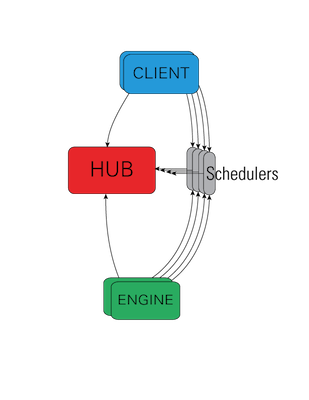

In [49]:
from IPython.core.display import *
Image(filename="figs/wideView400.png")

## Architecture overview

The IPython architecture consists of four components:

-   The IPython engine
-   The IPython hub
-   The IPython schedulers
-   The cluster client

These components live in the `ipyparallel` package. You'll need to install via conda or pip.

### IPython engine

The Engine is simply a remote Python namespace where your code is run,
and is a modified version of the kernel used elsewhere in IPython.

### IPython controller

The Schedulers and Hub together comprise the Controller, which provides
a single connection point for your clients and engines.  Each Scheduler is a small GIL-less function in C provided
by pyzmq (the Python load-balancing scheduler being an exception),
which handle relaying of messages between clients and engines.

The Hub can be viewed as an über-logger, which monitors all communication
between clients and engines, and logs to a database (SQLite or MongoDB)
for later retrieval.  The Hub is not involved in execution in any way,
and a slow Hub cannot slow down submission of tasks.

#### Schedulers

All actions that can be performed on the engine go through a Scheduler.
While the engines themselves block when user code is run, the schedulers
hide that from the user to provide a fully asynchronous interface to a
set of engines.  

## ØMQ and PyZMQ

All of this is implemented with the lovely ØMQ messaging library,
and pyzmq, the lightweight Python bindings, which allows very fast
zero-copy communication of objects like numpy arrays.

## IPython client and views

There is one primary object, the `Client`, for
connecting to a cluster. For each execution model, there is a
corresponding `View`, and you manipulate how your work should
be assigned on the cluster by creating different views or
manipulating attributes of views.

The two basic views:

-   The `DirectView` class for explicit addressing.
-   The `LoadBalancedView` class for destination-agnostic
    scheduling.

## Getting Started

Your notebook config (e.g. `~/.jupyter/jupyter_notebook_config.json`) should look like this:
```json
{
  "NotebookApp": {
    "nbserver_extensions": {
      "jupyterlab": false,
      "ipyparallel.nbextension": true
    }
  }
}
```

## Starting the IPython controller and engines

To follow along with this tutorial, you will need to start the IPython
controller and four IPython engines. The simplest way of doing this is
to use the `ipcluster` command:

    $ ipcluster start -n 4

There isn't time to go into it here, but ipcluster can be used to start engines
and the controller with various batch systems including:

* SGE
* PBS
* LSF
* MPI
* SSH
* WinHPC

More information on starting and configuring the IPython cluster in 
[the ipyparallel docs](https://ipyparallel.readthedocs.io/en/latest/intro.html#examples).

Once you have started the IPython controller and one or more engines,
you are ready to use the engines to do something useful. 

To make sure everything is working correctly, let's do a very simple demo:

In [ ]:
import ipyparallel as ipp
from ipyparallel import Client
rc = Client()
rc.block = True

In [ ]:
rc.ids

In [ ]:
def mul(a,b):
    return a*b

In [ ]:
mul(5,6)

What does it look like to call this function remotely?

Just turn `f(*args, **kwargs)` into `view.apply(f, *args, **kwargs)`!

In [ ]:
rc[0].apply(mul, 5, 6)

And the same thing in parallel?

In [ ]:
rc[:].apply(mul, 5, 6)

In practice, we make this a 'direct view', which is a simple but very useful multiplexer:

In [ ]:
dview = rc[:]

Python has a builtin map for calling a function with a variety of arguments

In [ ]:
list(map(mul, range(1,10), range(2,11)))

So how do we do this in parallel?

In [ ]:
view = rc.load_balanced_view()
list(view.map(mul, range(1,10), range(2,11)))

## Asynchronous execution

In [ ]:
rc.block

In [ ]:
rc.block = False

In [ ]:
dview = rc[:]
dview.apply(mul, 5, 6)

In [ ]:
_.get()

In [ ]:
__.r

In [ ]:
___.result()

In [ ]:
view = rc.load_balanced_view()
view.map(mul, range(1,10), range(2,11))

In [ ]:
_.r

### Launch Dask from IPyParallel

In [ ]:
from ipyparallel import Client
c = Client()  # connect to IPyParallel cluster
e = c.become_distributed()  # start dask on top of IPyParallel
e

In [ ]:
futures = e.map(mul, range(1,10), range(2,11))

In [ ]:
[future.result() for future in futures]